# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-gu7wi44z
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-gu7wi44z
     |████████████████████████████████| 952kB 9.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.1-cp36-none-any.whl size=71928 sha256=3fbb38756de6744041d4ec3cd8ccae0ae4c368ebf050d26be0258a20f7803cae
  Stored in directory: /tmp/pip-ephem-wheel-cache-7kis4kbk/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
import os
from os.path import isfile, join
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import sys
from torchvision.models import resnext50_32x4d, resnet50, resnext101_32x8d
from torchvision import transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensor

In [ ]:
!unzip /content/drive/My\ Drive/dataset.zip -d MyDataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: MyDataset/dataset/dataset/val/class_101/00048.jpg  
  inflating: MyDataset/dataset/dataset/val/class_101/00049.jpg  
   creating: MyDataset/dataset/dataset/val/class_102/
  inflating: MyDataset/dataset/dataset/val/class_102/00000.jpg  
  inflating: MyDataset/dataset/dataset/val/class_102/00001.jpg  
  inflating: MyDataset/dataset/dataset/val/class_102/00002.jpg  
  inflating: MyDataset/dataset/dataset/val/class_102/00003.jpg  
  inflating: MyDataset/dataset/dataset/val/class_102/00004.jpg  
  inflating: MyDataset/dataset/dataset/val/class_102/00005.jpg  
  inflating: MyDataset/dataset/dataset/val/class_102/00006.jpg  
  inflating: MyDataset/dataset/dataset/val/class_102/00007.jpg  
  inflating: MyDataset/dataset/dataset/val/class_102/00008.jpg  
  inflating: MyDataset/dataset/dataset/val/class_102/00009.jpg  
  inflating: MyDataset/dataset/dataset/val/class_102/00010.jpg  
  inflating: MyDataset/dataset/da

In [ ]:
train_transform = transforms.Compose([transforms.RandomApply(
    torch.nn.ModuleList([transforms.RandomHorizontalFlip(p=0.5),
                         transforms.RandomVerticalFlip(p=0.5),
                         transforms.RandomRotation(90)]), p=0.5),

                         transforms.ToTensor(), 
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.RandomApply(
    torch.nn.ModuleList([transforms.RandomHorizontalFlip(p=0.5),
                         transforms.RandomVerticalFlip(p=0.5),
                         transforms.RandomRotation(90)]), p=0.2),

                         transforms.ToTensor(), 
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

#transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

train_dataset = torchvision.datasets.ImageFolder('/content/MyDataset/dataset/dataset/train', transform=train_transform)
#train_dataset2 = torchvision.datasets.ImageFolder('/content/MyDataset/dataset/dataset/train', transform=train_transform)
#train_dataset = torch.utils.data.ConcatDataset(datasets=[train_dataset1, train_dataset2])

val_dataset = torchvision.datasets.ImageFolder('/content/MyDataset/dataset/dataset/val', transform=val_transform)

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции

In [ ]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cpu"):
    predicted_classes = np.array([])
    true_classes = np.array([])
    train_loss = np.array([])
    for images, targets in train_dataloader:
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        true_classes = np.append(true_classes, targets.cpu().detach().numpy())
        predicted_classes = np.append(predicted_classes, outputs.argmax(1).cpu().detach().numpy())
        train_loss = np.append(train_loss, loss.item())

    return np.mean(train_loss), predicted_classes, true_classes

In [ ]:
def predict(model, val_dataloder, criterion, device="cpu"):
    model.eval()
    with torch.no_grad():
        predicted_classes = np.array([])
        true_classes = np.array([])
        val_loss = np.array([])
        for images, targets in val_dataloader:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            true_classes = np.append(true_classes, targets.cpu().detach().numpy())
            predicted_classes = np.append(predicted_classes, outputs.argmax(1).cpu().detach().numpy())
            val_loss = np.append(val_loss, loss.item())

    return np.mean(val_loss), predicted_classes, true_classes

In [ ]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cpu", n_epochs=10, scheduler=None):
    train_accuracy = []
    val_accuracy = []
    train_loss = []
    val_loss = []
    for epoch in range(n_epochs):
        print('###############################################################')
        print('Epoch', epoch + 1)
        t_loss, t_y_pred, t_y_true = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        v_loss, v_y_pred, v_y_true = predict(model, val_dataloader, criterion, device)
        t_acc = round(accuracy_score(t_y_pred, t_y_true) * 100, 2)
        v_acc = round(accuracy_score(v_y_pred, v_y_true) * 100, 2)

        train_accuracy.append(t_acc)
        val_accuracy.append(v_acc)
        train_loss.append(t_loss)
        val_loss.append(v_loss)

        print("Train_loss: {}. Val_loss: {}. Train_accuracy: {}. Val_accuracy: {}.".format(t_loss, v_loss, t_acc, v_acc))

        if scheduler is not None:
            scheduler.step()
    
    return train_accuracy, val_accuracy, train_loss, val_loss

In [ ]:
def visualisation(train_acc, val_acc, train_loss, val_loss):    
    plt.figure(figsize=(8,6))
    plt.plot(train_acc, label='Train accuracy', c='blue')
    plt.plot(val_acc, label='Validation accuracy', c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.plot(train_loss, label='Train loss', c='blue')
    plt.plot(val_loss, label='Validation loss', c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

### Модель

In [ ]:
model = resnet50(pretrained=True)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
for param in model.parameters():
    param.requires_grad = True
model.fc = torch.nn.Sequential(nn.Linear(2048, 1024),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(1024, 200))
model.to(device)
print()

### Обучение

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=32,
                                          shuffle=True, 
                                          num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=32,
                                         shuffle=True, 
                                         num_workers=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)
n_epochs = 5

Простой тест на проверку правильности написанного кода

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

tests passed


Запустить обучение можно в ячейке ниже.

In [ ]:
train_accuracy, val_accuracy, train_loss, val_loss = train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

###############################################################
Epoch 1
Train_loss: 3.340028543395996. Val_loss: 2.4406543722548806. Train_accuracy: 24.63. Val_accuracy: 40.19.
###############################################################
Epoch 2
Train_loss: 2.285559316749573. Val_loss: 2.0948483475480977. Train_accuracy: 43.74. Val_accuracy: 48.39.
###############################################################
Epoch 3
Train_loss: 1.9130707332229615. Val_loss: 1.9382626298136605. Train_accuracy: 51.94. Val_accuracy: 51.29.
###############################################################
Epoch 4
Train_loss: 1.6461646740341187. Val_loss: 1.822168983971349. Train_accuracy: 57.94. Val_accuracy: 55.21.
###############################################################
Epoch 5
Train_loss: 1.433511418800354. Val_loss: 1.8087690562105025. Train_accuracy: 62.9. Val_accuracy: 56.2.


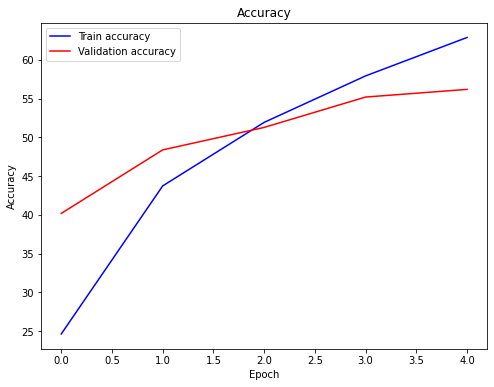

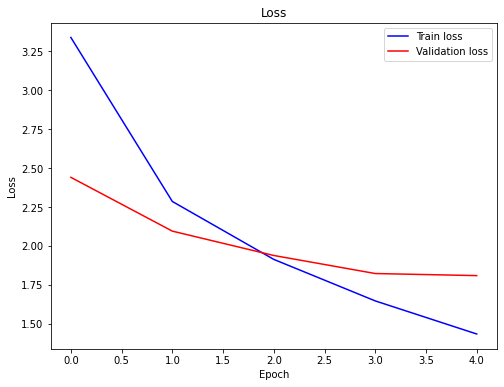

In [ ]:
visualisation(train_accuracy, val_accuracy, train_loss, val_loss)

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print('Точность =', round(accuracy * 100, 2), '%')
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Точность = 56.29 %
Оценка за это задание составит 5 баллов


__Ваш отчёт о проделанных экспериментах__: 

1) Сперва я обучил простую сверточную нейронную сеть, чтобы проверить правильность работы написанных функций.

2) Далее стал перебирать предобученные модели в библиотеке torchvision.models, в которых обучал только последний fc слой. Спустя большое количество экспериментов понял, что это не самый лучший вариант, потому что только в редких случаях точность достигала 44-45 процентов.

3) Попробовал обучать не только последний добавленный слой, но и все предыдущие. И уже на второй эпохе точность достигла требуемого значения в 44%, а на четвертой эпохе достигла 52%.

4) Также я проделал много экспериментов с подбором аугментаций, потому что модели быстро переобучались на трейне.

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

В предыдущей ячейке видно, что точность составила __55.84%__. Таким образом, считаю, что бонусная часть выполнена.

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

### Импорт

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
# we will need this library to process the labeling
! pip install xmltodict

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-szgs5v6n
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-szgs5v6n
  Created wheel for albumentations: filename=albumentations-0.5.1-cp36-none-any.whl size=71852 sha256=374fc81611da0a94f25c99ef28fb29dfdaa4ace228c01eeed1a3e75a5f254b5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jcphpiv3/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.1
    Uninstalling albumentations-0.5.1:
      Successfully uninstalled albumentations-0.5.1


In [ ]:
import xmltodict, json

In [ ]:
!unzip /content/drive/My\ Drive/archive.zip -d ObjDetection

Archive:  /content/drive/My Drive/archive.zip
replace ObjDetection/test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Датасет мы за вас написали.

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import albumentations as A
from albumentations.pytorch import ToTensor
from warnings import filterwarnings
filterwarnings("ignore")


class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

### Вспомогательные функции

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

In [ ]:
def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    # правильные прямоугольники
    gt_bboxes = target_true['boxes'].numpy()
    gt_labels = target_true['labels'].numpy()

    # предсказания модели
    dt_bboxes = target_pred['boxes'].numpy()
    dt_labels = target_pred['labels'].numpy()
    dt_scores = target_pred['scores'].numpy()

    results = []
    # для каждого прямоугольника из предсказания находим максимально близкий прямоугольник среди ответов
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {'score': dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        
        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # для прямоугольника detection_id нашли правильный ответ, который имеет IoU больше 0.5 
            detection_result_dict['TP'] = 1
            # удаляем эти прямоугольники из данных, чтобы больше не матчить с ними
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict['TP'] = 0

        results.append(detection_result_dict)

    # возвращаем результат, для кажого прямоугольника говорим, смогли ли сматчить его с чем то из ответов
    return results

In [ ]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true['labels'].shape[0]

                # матчим ответы с правильными боксами
                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k['score'], reverse=True)

    # считаем точность и полноту, чтобы потом посчитать mAP как auc
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]['TP'] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]['TP'] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]['TP']) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

### Задание

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    train_loss = np.array([])
    criterion = nn.CrossEntropyLoss()
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        if not type(targets) is dict:
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        else:
            targets = [{k: v.to(device) for k, v in targets.items()}]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss = np.append(train_loss, float(losses.cpu().detach().numpy()))

    return np.mean(train_loss)


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10, scheduler=None):
    train_loss = []
    test_mAP = []
    train_mAP = []
    for epoch in range(n_epochs):
        print('#######################################################')
        print('Epoch ', epoch + 1)
        t_loss = train_one_epoch(model, train_dataloader, optimizer, device)
        t_mAP = round(evaluate(model, train_dataloader, device), 3)
        v_mAP = round(evaluate(model, val_dataloader, device), 3)
        print("Loss on train: {} AUC on train: {} AUC on test: {}".format(t_loss, t_mAP, v_mAP))

        train_loss.append(t_loss)
        train_mAP.append(t_mAP)
        test_mAP.append(v_mAP)

        if scheduler is not None:
            scheduler.step()


In [ ]:
def get_detection_model(num_classes=3):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    '''for param in model.parameters():
        param.requires_grad = True'''

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_transform(train=False):                           
    if train:
        return A.Compose([A.Flip(p=0.7),
                          A.GaussNoise(p=0.4),
                          A.HueSaturationValue(p=0.3),
                          A.Normalize(),
                          ToTensor()], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
        
    return A.Compose([A.Flip(p=0.3),
                      A.GaussNoise(p=0.2),
                      A.HueSaturationValue(p=0.2),
                      A.Normalize(),
                      ToTensor()], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

train_transform = get_transform(train=True)
val_transform = get_transform()

train_dataset1 = FruitDataset("/content/ObjDetection/train_zip/train", transform=train_transform)
train_dataset2 = FruitDataset("/content/ObjDetection/train_zip/train", transform=train_transform)
train_dataset3 = FruitDataset("/content/ObjDetection/train_zip/train", transform=A.Compose([ToTensor()]))
val_dataset = FruitDataset("/content/ObjDetection/test_zip/test", transform=val_transform)

train_dataset = torch.utils.data.ConcatDataset(datasets=[train_dataset1, train_dataset2, train_dataset3])

### Обучение

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = get_detection_model(num_classes=4)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)

n_epochs = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.7)

train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs, scheduler)

#######################################################
Epoch  1
Loss on train: 0.3470387391885064 AUC on train: 0.684 AUC on test: 0.636
#######################################################
Epoch  2
Loss on train: 0.22564491139029835 AUC on train: 0.852 AUC on test: 0.727
#######################################################
Epoch  3
Loss on train: 0.1740525730817988 AUC on train: 0.937 AUC on test: 0.853
#######################################################
Epoch  4
Loss on train: 0.1413939953739564 AUC on train: 0.963 AUC on test: 0.854
#######################################################
Epoch  5
Loss on train: 0.11460831891537612 AUC on train: 0.975 AUC on test: 0.906
#######################################################
Epoch  6
Loss on train: 0.10006828659185231 AUC on train: 0.974 AUC on test: 0.902
#######################################################
Epoch  7
Loss on train: 0.087739965562722 AUC on train: 0.978 AUC on test: 0.919
################################

__Выведите итоговое качество модели__.

In [ ]:
auc = evaluate(model, val_dataloader, device)
print('AUC:', auc)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

AUC: 0.927006353960366
Оценка за это задание составит 4 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [ ]:
image, labels = next(iter(train_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

In [ ]:
from PIL import ImageDraw

image = torchvision.transform.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

AttributeError: ignored

In [ ]:
# YOUR CODE

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.